In [1]:
import jcopdl

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset & Dataloader

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
bs = 128

train_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [6]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 32, 32])

In [7]:
label2cat = train_set.classes
label2cat

['FAKE', 'REAL']

# Arsitektur & Config

In [8]:
from jcopdl.layers import conv_block, linear_block

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(512, 128, dropout=0.1),
            linear_block(128, 2, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [10]:
config =  set_config({
    "batch_size": bs
})

# Training Preparation

In [11]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model-pt")

# Training

In [12]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/782 [00:22<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.3709 | Test_cost  = 0.2545 | Train_score = 0.8296 | Test_score = 0.8944 |


Train:   0%|          | 0/782 [00:24<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.2487 | Test_cost  = 0.2329 | Train_score = 0.8981 | Test_score = 0.9055 |


Train:   0%|          | 0/782 [01:05<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.2148 | Test_cost  = 0.2111 | Train_score = 0.9141 | Test_score = 0.9145 |


Train:   0%|          | 0/782 [00:23<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1970 | Test_cost  = 0.1957 | Train_score = 0.9218 | Test_score = 0.9223 |


Train:   0%|          | 0/782 [00:23<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1864 | Test_cost  = 0.1928 | Train_score = 0.9261 | Test_score = 0.9241 |


Train:   0%|          | 0/782 [00:23<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1783 | Test_cost  = 0.1756 | Train_score = 0.9294 | Test_score = 0.9305 |


Train:   0%|          | 0/782 [00:21<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1691 | Test_cost  = 0.1733 | Train_score = 0.9339 | Test_score = 0.9323 |


Train:   0%|          | 0/782 [00:26<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.1669 | Test_cost  = 0.2121 | Train_score = 0.9349 | Test_score = 0.9136 |
==> EarlyStop patience =  1 | Best test_score: 0.9323


Train:   0%|          | 0/782 [00:24<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1585 | Test_cost  = 0.1792 | Train_score = 0.9390 | Test_score = 0.9295 |
==> EarlyStop patience =  2 | Best test_score: 0.9323


Train:   0%|          | 0/782 [02:24<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1548 | Test_cost  = 0.1676 | Train_score = 0.9393 | Test_score = 0.9332 |


Train:   0%|          | 0/782 [00:21<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.1490 | Test_cost  = 0.1631 | Train_score = 0.9421 | Test_score = 0.9349 |


Train:   0%|          | 0/782 [00:20<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.1435 | Test_cost  = 0.1784 | Train_score = 0.9446 | Test_score = 0.9291 |
==> EarlyStop patience =  1 | Best test_score: 0.9349


Train:   0%|          | 0/782 [00:22<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.1413 | Test_cost  = 0.1670 | Train_score = 0.9446 | Test_score = 0.9345 |
==> EarlyStop patience =  2 | Best test_score: 0.9349


Train:   0%|          | 0/782 [00:21<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.1362 | Test_cost  = 0.1581 | Train_score = 0.9478 | Test_score = 0.9382 |


Train:   0%|          | 0/782 [00:21<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.1309 | Test_cost  = 0.1610 | Train_score = 0.9489 | Test_score = 0.9386 |


Train:   0%|          | 0/782 [00:23<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.1279 | Test_cost  = 0.1698 | Train_score = 0.9505 | Test_score = 0.9355 |
==> EarlyStop patience =  1 | Best test_score: 0.9386


Train:   0%|          | 0/782 [00:23<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.1259 | Test_cost  = 0.1528 | Train_score = 0.9512 | Test_score = 0.9405 |


Train:   0%|          | 0/782 [00:24<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.1199 | Test_cost  = 0.1545 | Train_score = 0.9531 | Test_score = 0.9407 |


Train:   0%|          | 0/782 [00:21<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.1159 | Test_cost  = 0.1668 | Train_score = 0.9546 | Test_score = 0.9353 |
==> EarlyStop patience =  1 | Best test_score: 0.9407


Train:   0%|          | 0/782 [00:23<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.1145 | Test_cost  = 0.1654 | Train_score = 0.9552 | Test_score = 0.9369 |


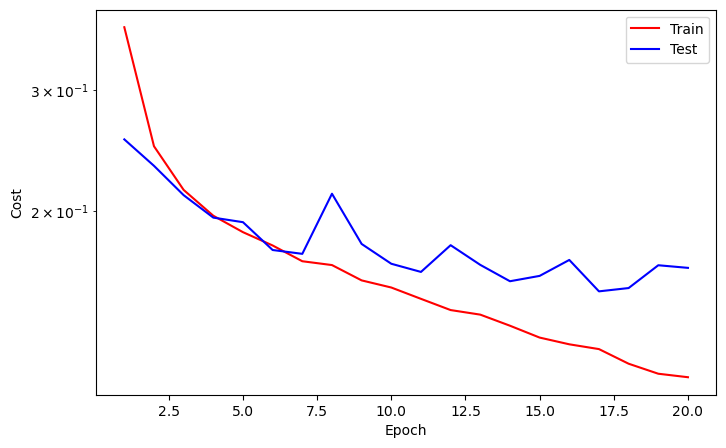

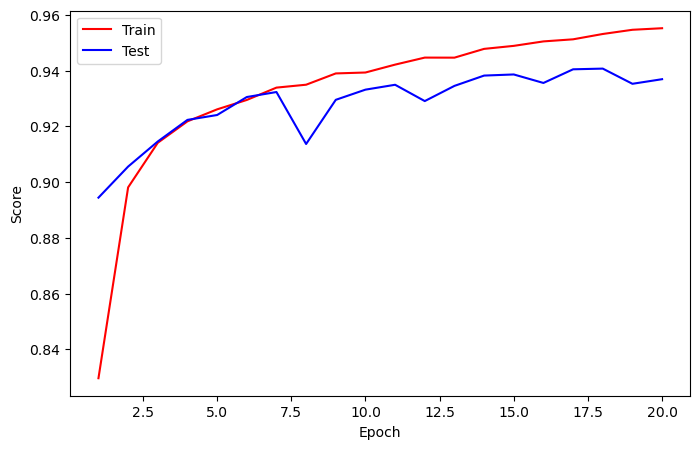

==> EarlyStop patience =  2 | Best test_score: 0.9407


Train:   0%|          | 0/782 [00:22<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.1111 | Test_cost  = 0.1501 | Train_score = 0.9571 | Test_score = 0.9416 |


Train:   0%|          | 0/782 [00:22<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.1058 | Test_cost  = 0.1636 | Train_score = 0.9590 | Test_score = 0.9368 |
==> EarlyStop patience =  1 | Best test_score: 0.9416


Train:   0%|          | 0/782 [00:20<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.1034 | Test_cost  = 0.1599 | Train_score = 0.9595 | Test_score = 0.9397 |
==> EarlyStop patience =  2 | Best test_score: 0.9416


Train:   0%|          | 0/782 [00:21<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.0988 | Test_cost  = 0.1533 | Train_score = 0.9623 | Test_score = 0.9425 |


Train:   0%|          | 0/782 [00:21<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.0983 | Test_cost  = 0.1614 | Train_score = 0.9620 | Test_score = 0.9389 |
==> EarlyStop patience =  1 | Best test_score: 0.9425


Train:   0%|          | 0/782 [00:21<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.0940 | Test_cost  = 0.1641 | Train_score = 0.9638 | Test_score = 0.9394 |
==> EarlyStop patience =  2 | Best test_score: 0.9425


Train:   0%|          | 0/782 [00:23<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.0891 | Test_cost  = 0.1625 | Train_score = 0.9659 | Test_score = 0.9412 |
==> EarlyStop patience =  3 | Best test_score: 0.9425


Train:   0%|          | 0/782 [00:24<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.0897 | Test_cost  = 0.1742 | Train_score = 0.9652 | Test_score = 0.9431 |


Train:   0%|          | 0/782 [00:22<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.0842 | Test_cost  = 0.1646 | Train_score = 0.9675 | Test_score = 0.9397 |
==> EarlyStop patience =  1 | Best test_score: 0.9431


Train:   0%|          | 0/782 [00:22<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.0831 | Test_cost  = 0.1620 | Train_score = 0.9681 | Test_score = 0.9416 |
==> EarlyStop patience =  2 | Best test_score: 0.9431


Train:   0%|          | 0/782 [00:22<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.0811 | Test_cost  = 0.1597 | Train_score = 0.9684 | Test_score = 0.9452 |


Train:   0%|          | 0/782 [00:22<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.0773 | Test_cost  = 0.1804 | Train_score = 0.9697 | Test_score = 0.9396 |
==> EarlyStop patience =  1 | Best test_score: 0.9452


Train:   0%|          | 0/782 [00:21<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.0759 | Test_cost  = 0.1665 | Train_score = 0.9705 | Test_score = 0.9425 |
==> EarlyStop patience =  2 | Best test_score: 0.9452


Train:   0%|          | 0/782 [00:22<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.0732 | Test_cost  = 0.1640 | Train_score = 0.9716 | Test_score = 0.9428 |
==> EarlyStop patience =  3 | Best test_score: 0.9452


Train:   0%|          | 0/782 [00:22<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.0717 | Test_cost  = 0.1779 | Train_score = 0.9723 | Test_score = 0.9427 |
==> EarlyStop patience =  4 | Best test_score: 0.9452


Train:   0%|          | 0/782 [00:23<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.0692 | Test_cost  = 0.1844 | Train_score = 0.9727 | Test_score = 0.9412 |
==> EarlyStop patience =  5 | Best test_score: 0.9452
==> Execute Early Stopping at epoch: 36 | Best test_score: 0.9452
==> Best model is saved at model


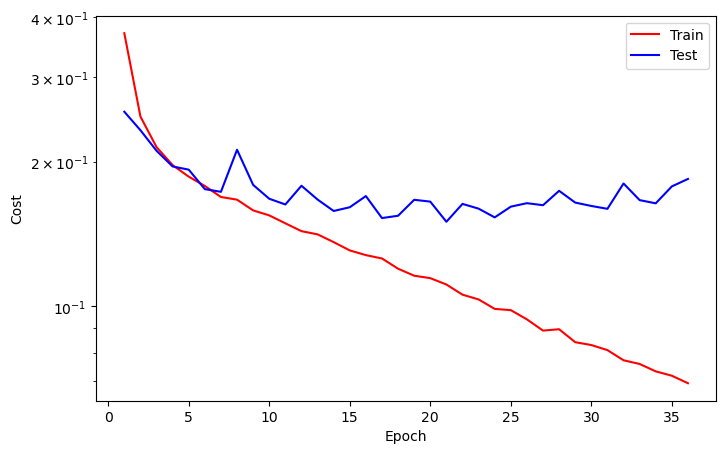

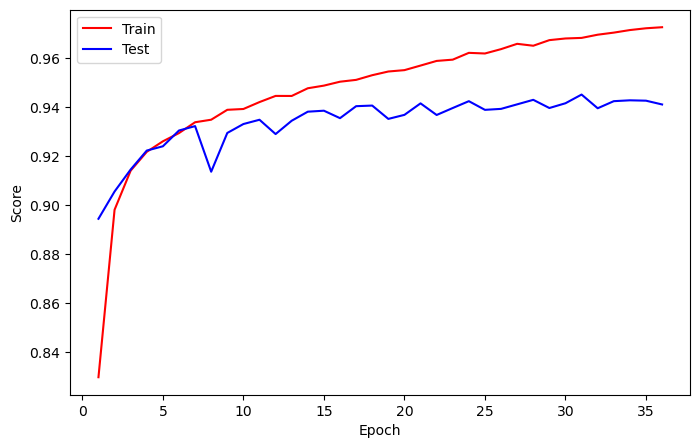

In [13]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

Best test score = 0.9452

# Predict

In [21]:
weights = torch.load("model/weights_best.pth", map_location="cpu")

model = CNN()
model.load_state_dict(weights)
model = model.to(device)

In [22]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [23]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')

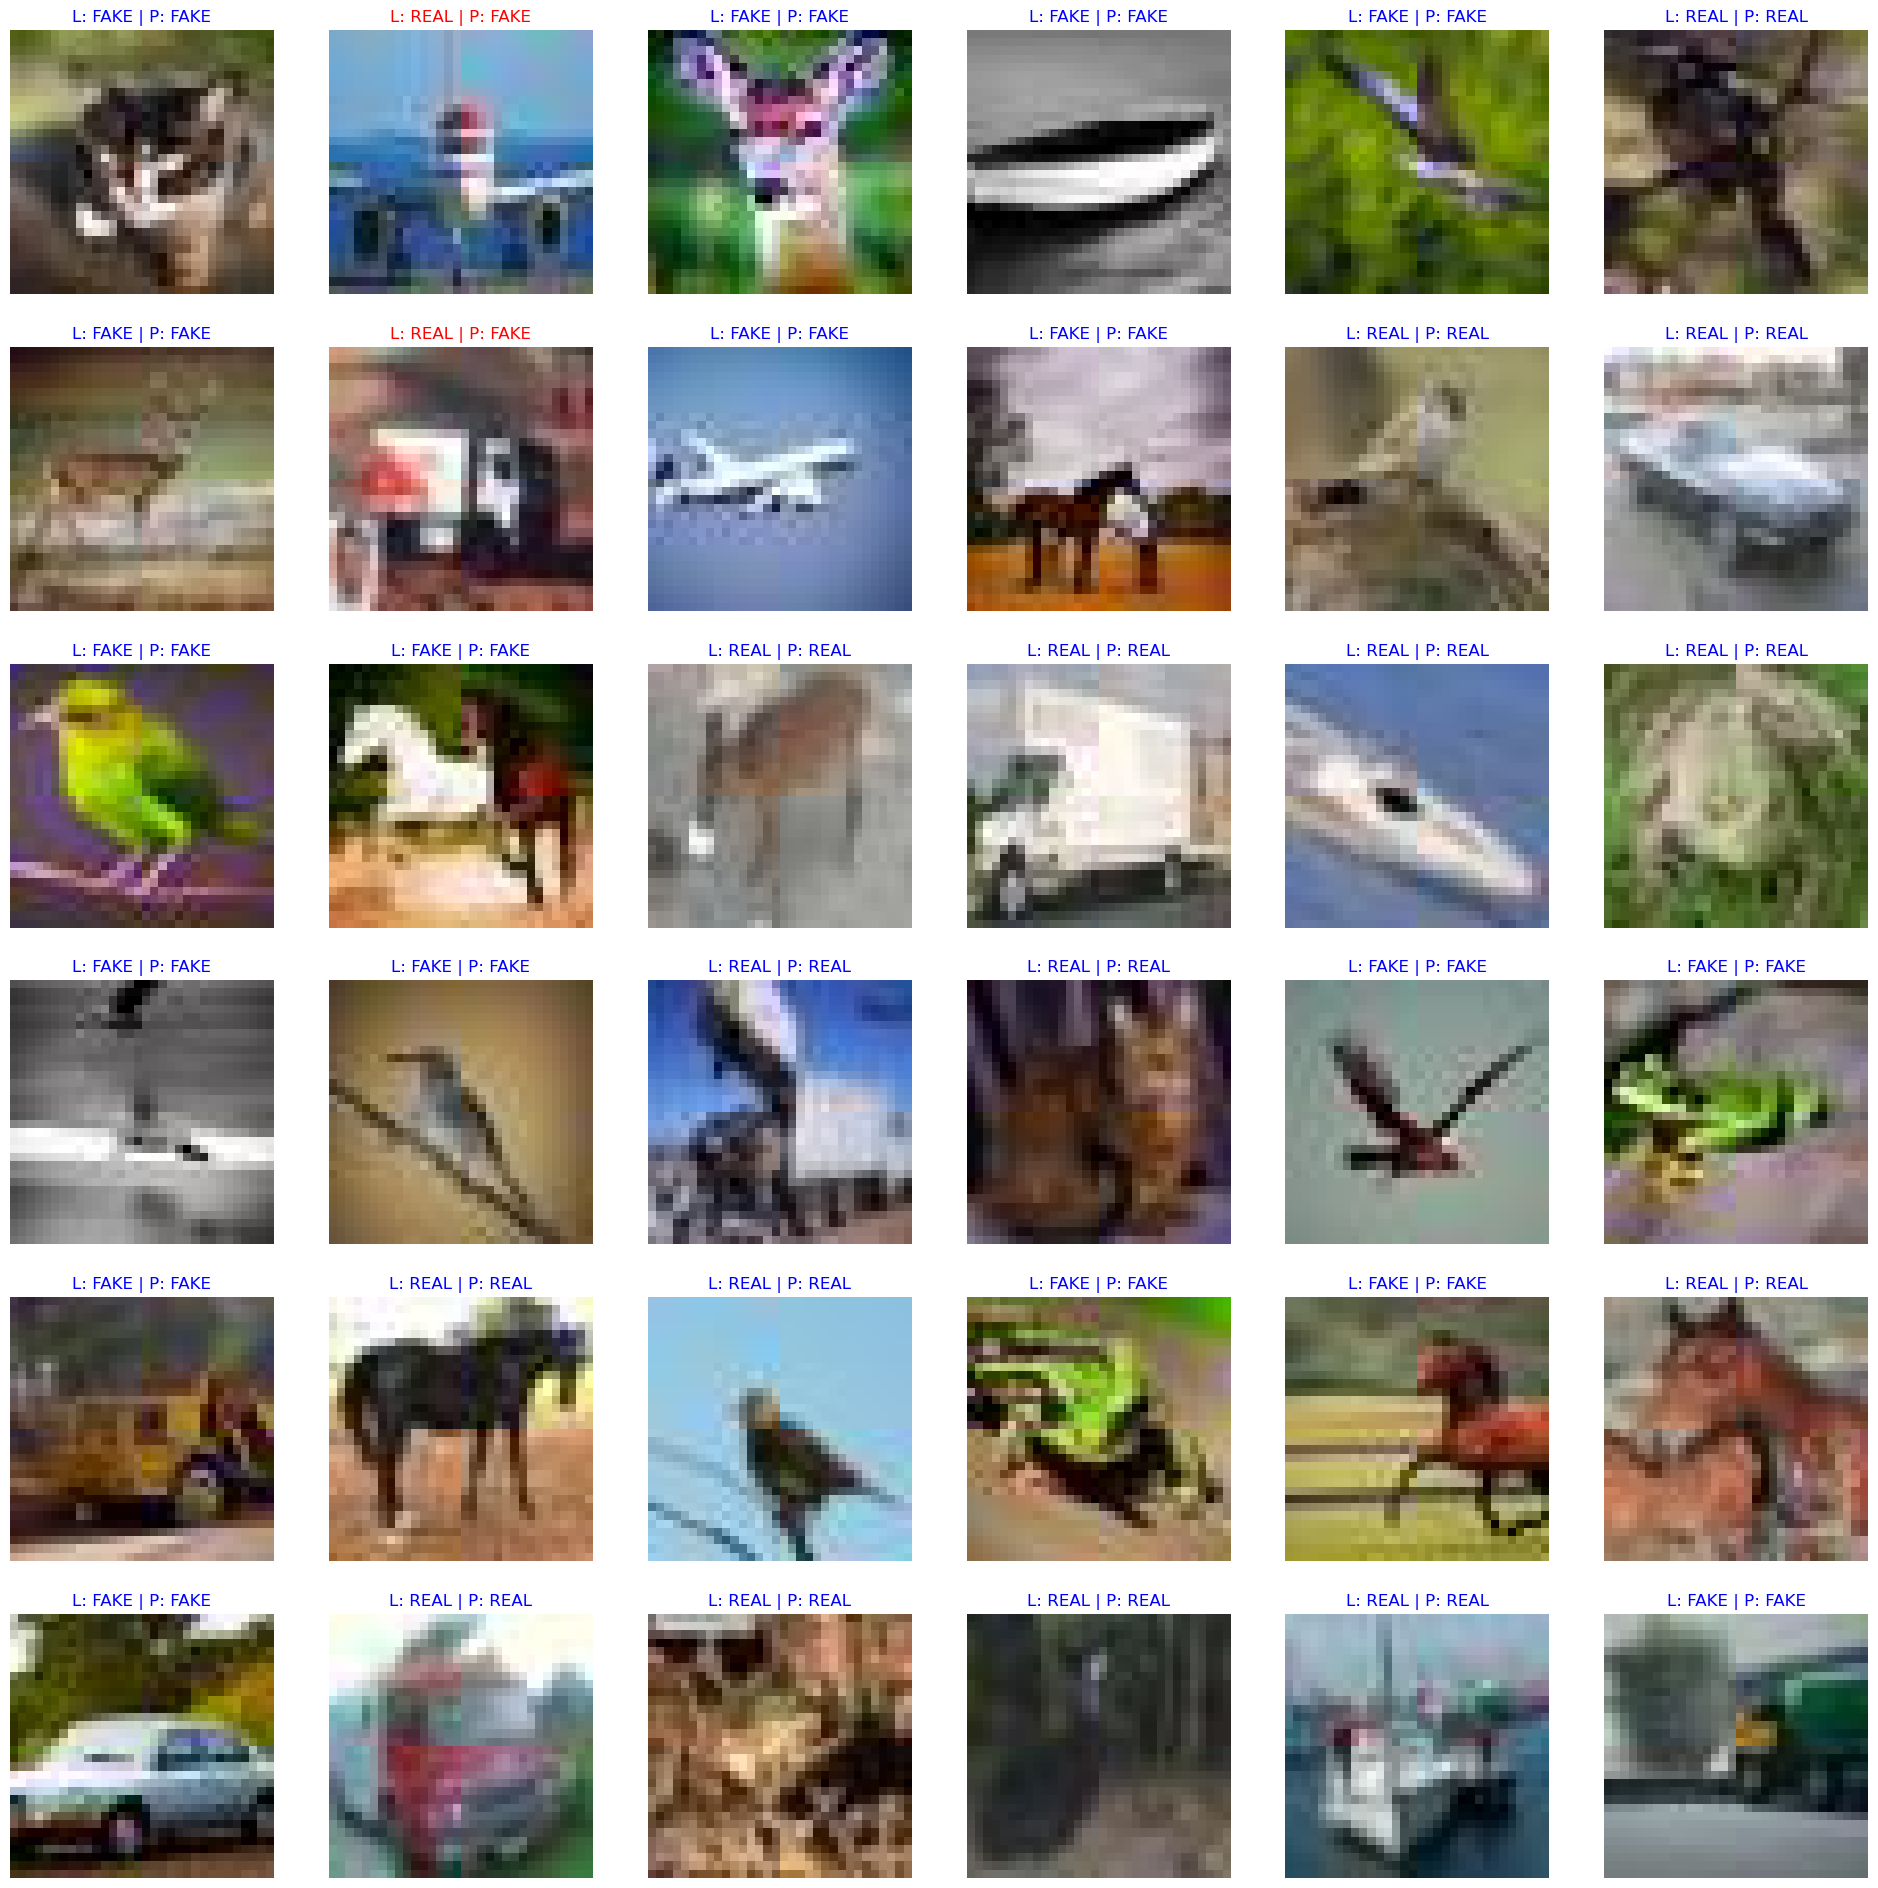

In [24]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'b'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');